> 🚨 **WARNING** 🚨
>
> Many cells in this notebook will not show up when viewed on GitHub. Please view the HTML version of this notebook in the [docs](https://docs.rastervision.io/en/latest/usage/tutorials/index.html).

# Working with pre-chipped datasets

It is not uncommon for geospatial datasets to be released in a "pre-chipped" form; i.e., not as large GeoTIFFs, but as non-georeferenced chips/tiles/patches in ordinary image formats such as PNG or JPEG.

In such scenarios, you do not necessarily need to use Raster Vision to read this data and train a model. In fact, you can train a model outside of Raster Vision and then use Raster Vision to run it over GeoTIFFs, as shown in the ["Using Raster Vision with Lightning"](./lightning_workflow.ipynb) tutorial.

Nevertheless, Raster Vision *is* capable of training with ordinary images and this tutorial notebook will walk you through examples for each of the three supported computer vision tasks. Note that this notebook only demonstrates how to read these datasets, but that is all that is needed; once you have instantiated these dataset classes, the rest of the [training](./train.ipynb) and [prediction](pred_and_eval_ss.ipynb) procedure is identical to that for non-chipped geo-referenced data.

<hr style="border:2px solid gray">

## The `ImageDataset` class

### Supported image formats

Each ImageDataset subclass is capable of reading all image formats supported by [pillow](https://pillow.readthedocs.io/en/stable/) (``.png``, ``.jp[e]g``, ``.tif[f]``, ``.bmp``, and more) plus the ``numpy`` format, `.npy`.

---

### Dataset

For this example, we will use the [Extended Optical Remote Sensing Saliency Detection (EORSSD) Dataset](https://github.com/rmcong/EORSSD-dataset).

_Zhang, Qijian, Runmin Cong, Chongyi Li, Ming-Ming Cheng, Yuming Fang, Xiaochun Cao, Yao Zhao, and Sam Kwong. "Dense attention fluid network for salient object detection in optical remote sensing images." IEEE Transactions on Image Processing 30 (2020): 1305-1317._

Below we download (63 MB) and unzip the data.

In [14]:
!wget "https://github.com/rmcong/EORSSD-dataset/raw/master/EORSSD.zip"
!apt-get install unzip -y
!unzip -q "EORSSD.zip" -d "EORSSD"
!ls "EORSSD"

test-images  test-labels  train-images	train-labels


### Usage

In [1]:
import albumentations as A

from rastervision.pytorch_learner import SemanticSegmentationImageDataset

ds = SemanticSegmentationImageDataset(
    img_dir='EORSSD/train-images/',
    label_dir='EORSSD/train-labels/',
    transform=A.Resize(256, 256),
)
len(ds)

1400

We can read a data sample and the corresponding ground truth from the Dataset like so:

In [2]:
x, y = ds[0]
x.shape, y.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

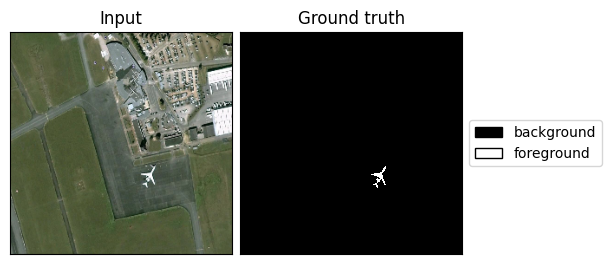

In [3]:
from rastervision.pytorch_learner import SemanticSegmentationVisualizer

viz = SemanticSegmentationVisualizer(
    class_names=['background', 'foreground'], class_colors=['black', 'white'])
viz.plot_batch(x.unsqueeze(0), y.unsqueeze(0), show=True)

---

### Dataset

For this example, we will use the [Airbus Aircraft Detection dataset](https://www.kaggle.com/datasets/airbusgeo/airbus-aircrafts-sample-dataset).

You will need to manually download the dataset (92 MB) from here: https://www.kaggle.com/datasets/airbusgeo/airbus-aircrafts-sample-dataset.

The cells below assume that the data has been unzipped into an `airbus/` directory.

In [1]:
!ls "airbus/"

LICENSE.txt  README.md	annotations.csv  annotations.json  extras  images


#### Transform annotations into COCO format

- Add a `bbox` column representing bounding boxes in `xywh` format and delete the old `geometry` column.
- Add a `category_id` column representing class IDs.

In [1]:
import pandas as pd
from shapely.geometry import Polygon

from rastervision.core.box import Box
from rastervision.pipeline.file_system.utils import json_to_file

In [31]:
class_names = ['Airplane', 'Truncated_airplane']
ann_df = pd.read_csv('airbus/annotations.csv')
ann_df.loc[:, 'bbox'] = [Box.from_shapely(Polygon(eval(g))).to_xywh() for g in ann_df.geometry]
ann_df = ann_df.drop(columns='geometry')
ann_df.loc[:, 'category_id'] = [class_names.index(c) for c in ann_df['class']]

Convert to JSON and save to file:

In [24]:
ann_json = {
    'images': [dict(id=image_id, file_name=image_id) for image_id in ann_df.image_id.unique()],
    'annotations': ann_df.to_dict(orient='records'),
}
json_to_file(ann_json, 'airbus/annotations.json')

### Usage

The annotations are now ready to be used:

In [4]:
import albumentations as A

from rastervision.pytorch_learner import ObjectDetectionImageDataset

ds = ObjectDetectionImageDataset(
    img_dir='airbus/images/',
    annotation_uri='airbus/annotations.json',
    transform=A.Resize(1024, 1024),
)
len(ds)

103

We can read a data sample and the corresponding ground truth from the Dataset like so:

In [5]:
x, y = ds[0]
x.shape, y

(torch.Size([3, 1024, 1024]),
 <rastervision.pytorch_learner.object_detection_utils.BoxList at 0x7f22380d5460>)

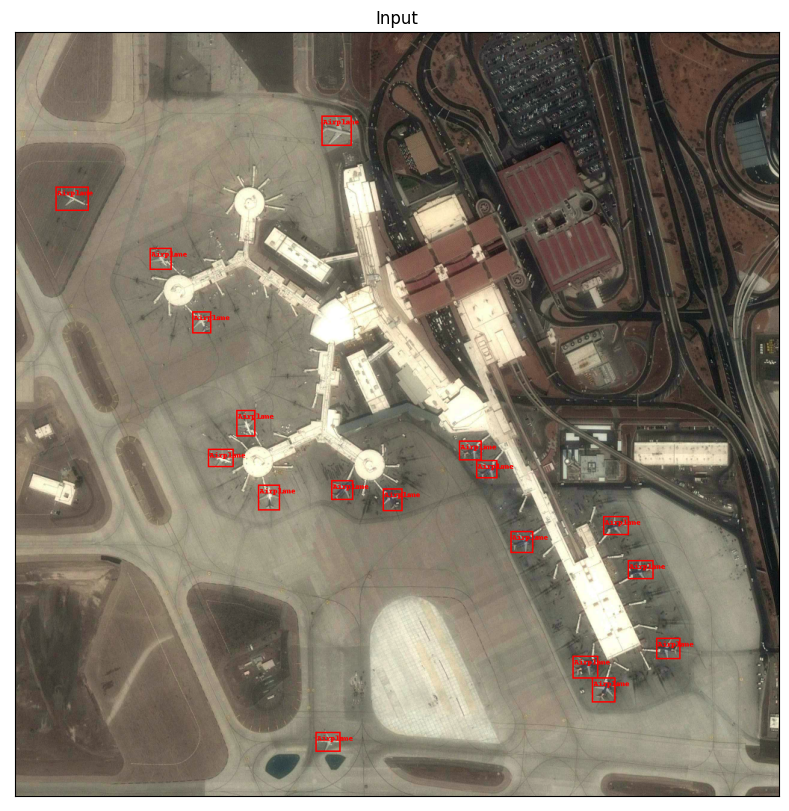

In [6]:
from rastervision.pytorch_learner import ObjectDetectionVisualizer

viz = ObjectDetectionVisualizer(
    class_names=['Airplane', 'Truncated_airplane'], 
    class_colors=['red', 'green'])
viz.scale = 8
viz.plot_batch(x.unsqueeze(0), [y], show=True)

---

### Dataset

For this example, we will use the [EuroSat Dataset](https://github.com/phelber/eurosat).

_Helber, Patrick, Benjamin Bischke, Andreas Dengel, and Damian Borth. "Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification." IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing 12, no. 7 (2019): 2217-2226._

Below we download (94 MB) and unzip the data.

In [11]:
!wget "https://madm.dfki.de/files/sentinel/EuroSAT.zip"
!apt-get install unzip -y
!unzip -q "EuroSAT.zip" -d "EuroSAT"
!mv "EuroSAT/2750/"* "EuroSAT/" && rm -rf "EuroSAT/2750"
!ls "EuroSAT"

AnnualCrop  HerbaceousVegetation  Industrial  PermanentCrop  River
Forest	    Highway		  Pasture     Residential    SeaLake


### Usage

In [13]:
import albumentations as A

from rastervision.pytorch_learner import ClassificationImageDataset

ds = ClassificationImageDataset(
    data_dir='EuroSAT',
    # You can pass in a list explicitly if you want to enforce a specific
    # class-name to class-ID mapping.
    class_names=None,
    transform=A.Resize(256, 256),
)
len(ds)

27000

We can read a data sample and the corresponding ground truth from the Dataset like so:

In [22]:
x, y = ds[10_000]
x.shape, y

(torch.Size([3, 256, 256]), tensor(3))

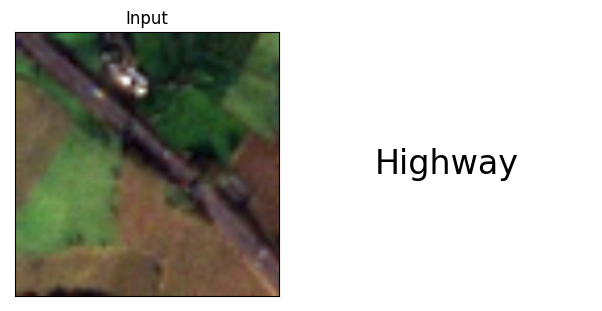

In [23]:
from rastervision.pytorch_learner import ClassificationVisualizer

viz = ClassificationVisualizer(class_names=ds.orig_dataset.classes)
viz.plot_batch(x.unsqueeze(0), y.unsqueeze(0), show=True)